# Deliverable 4: Final Report

## 1. Introduction


Since the beginning of the covid-19 pandemic in 2020, remote work has been on the rise globally (Brynjolfsson, E. et al., 2020). This drastic change in the way companies operate poses numerous challenges and opportunities for both employers and employees. Given the potential increases in productivity (Galanti, Teresa et al., 2021) among remote workers and the obvious decrease in operating costs for companies, it would be insightful to see if these factors point to a difference in salaries among data science professionals. Since the nature of most data science jobs allows fully remote work, it would be informative to look at salary differences between fully-remote and conventional work.

This raises an interesting question: **does salary differ between full-remote and conventional positions for full-time data science professionals?** We will provide an estimate of the mean salary for both groups(remote and conventional workers) and conduct a two-sample t-test in an attepmt to provide evidence for there being a difference between the two groups. Given the skewed nature of the salaries in our dataset, we will use the inter-quartile range to quantify the spread of the data. 


To answer our question, we discovered a dataset originally aggregated by [ai-jobs.net](https://salaries.ai-jobs.net/) through [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). This dataset includes 607 observations with 11 factors: year, experience level, full/part-time, job titles, salary values in different currencies, employees location, remote ratio, company locations, and company sizes (more detials see 2.2).  We take the `salary_in_usd` as our response variables and take `remote_ratio` as our explanatory variable.

In [96]:
library(readr)
library(tidyr)
library(infer)
library(repr)
library(dbplyr)
library(tidyverse)
library(cowplot)
library(ggplot2)
library(digest)
library(lubridate)
library(scales)

## 2. Methods and Results
*Here is where you’ll include your work from the “Preliminary Results” in your proposal, along with the additional results you planned to conduct, as indicated in the “Methods: Plan” section of your proposal.* 

*Be sure to **incorporate feedback from the teaching team and your peers (as relevant)**, or **make any improvements based on your own improved understanding of the project** (now that more time has passed since the proposal).*



*Specifically, in addition to what is requested in the “Preliminary Results” section of the proposal, we are looking for the following components:*

- ***Describe in written English the methods you used** to perform your analysis from beginning to end that **narrates the code** the does the analysis.*
- *Make sure to interpret the results you obtain. It’s not enough to just state what a 90% confidence interval is, for example.*
- *Ensure your tables and/or figures are labeled with a figure/table number.*
- *Do you think one of **bootstrapping or asymptotics is more appropriate than the other**? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.*

### 2.x Preliminary results and improvements in plan

### 2.x Methods and analysis

- choose only mean and given up median for normality condition  ?

- narrow down focus to only company location 
- take them as two groups/populations to compare the difference

- is the overall sample mean still meaningful and indicative? 



### 2.1 Data import and cleaning

In [64]:
# Given the absence of an official API for R language from Kaggle, 
# we had to transfer the .csv file to Github for the required direct import process.

ds_salaries <- read_csv("https://raw.githubusercontent.com/CalicoCalliope/ds_salaries_r/main/ds_salaries.csv")

glimpse(ds_salaries)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 607
Columns: 12
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…
$ work_year          <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 202…
$ experience_level   <chr> "MI", "SE", "SE", "MI", "SE", "EN", "SE", "MI", "MI…
$ employment_type    <chr> "FT", "FT", "FT", "FT", "FT", "FT", "FT", "FT", "FT…
$ job_title          <chr> "Data Scientist", "Machine Learning Scientist", "Bi…
$ salary             <dbl> 70000, 260000, 85000, 20000, 150000, 72000, 190000,…
$ salary_currency    <chr> "EUR", "USD", "GBP", "USD", "USD", "USD", "USD", "H…
$ salary_in_usd      <dbl> 79833, 260000, 109024, 20000, 150000, 72000, 190000…
$ employee_residence <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US…
$ remote_ratio       <dbl> 0, 0, 50, 0, 50, 100, 100, 50, 100, 50, 0, 0, 0, 10…
$ company_location   <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US…
$ company_size       <chr> "L", "S", "M", "S", "L", "L", "S", "L", "L", "S", "…


### 2.2 Data cleaning and wrangling

Since our interests are on **remote work** and **salaries** for **all fulltime** data science professionals **globally**, we cleaned the data as follows:

In [65]:
df <- ds_salaries %>%

    # filter only fulltime position to create sample for the targeted population:
    filter(employment_type=="FT") %>% 

    select(salary_in_usd,  # select converted salaries so all values are on the same scale
           remote_ratio,  # select remote ratio as the explanatory variable
           
           # include only the following potential indicators for more in-depth interests and future questions:
           company_location,  # shown in ISO 3166 country code
           experience_level)  # EN: Entry-level, MI: Mid-level, SE: Senior-level, EX: Executive-level

head(df)

salary_in_usd,remote_ratio,company_location,experience_level
<dbl>,<dbl>,<chr>,<chr>
79833,0,DE,MI
260000,0,JP,SE
109024,50,GB,SE
20000,0,HN,MI
150000,50,US,SE
72000,100,US,EN


Given the purpose of the key question and the distribution of `remote_ratio` of this dataset:

In [68]:
# Although remote_ration is a double<dbl>, it has only three values: 
# 0%(onsite), 50%(hybrid), 100% (fully remote).  

ratio_value_count <- df %>% 
    summarise(onsite = sum(remote_ratio == 0),
              hybrid = sum(remote_ratio == 50),
              fully_remote = sum(remote_ratio == 100))
              
ratio_value_count

onsite,hybrid,fully_remote
<int>,<int>,<int>
126,92,370


From here onward, we divide the data into two groups:
- 1. `fully_remote`
- 2. `non_fully_remote` or "conventional"

In [71]:
remote_binary <- df %>% 
    mutate(fully_remote = (remote_ratio == 100)) %>% 
    select(-remote_ratio) 

# 1. fully_remote: remote_ratio == 100, all 100%(fully-remote) 
fully_remote <- remote_binary %>% 
    filter(fully_remote == TRUE)
head(fully_remote)

# 2. non_fully_remote:  remote_ratio != 100, combine both 0%(onsite) and 50%(hybrid),
non_fully_remote <- remote_binary %>% 
    filter(fully_remote == FALSE)
head(non_fully_remote)

salary_in_usd,company_location,experience_level,fully_remote
<dbl>,<chr>,<chr>,<lgl>
72000,US,EN,TRUE
190000,US,SE,TRUE
135000,US,MI,TRUE
87000,US,MI,TRUE
85000,US,MI,TRUE
41689,JP,EN,TRUE


salary_in_usd,company_location,experience_level,fully_remote
<dbl>,<chr>,<chr>,<lgl>
79833,DE,MI,FALSE
260000,JP,SE,FALSE
109024,GB,SE,FALSE
20000,HN,MI,FALSE
150000,US,SE,FALSE
35735,HU,MI,FALSE


### 2.3 Data Exploration

#### 2.3.1 Raw data of overall sample

With our **sample mean** (sample median as extra reference), we plotted the raw data：

 The over all sample mean is 113468 USD, 
 and the over all sample median is 104196 USD.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


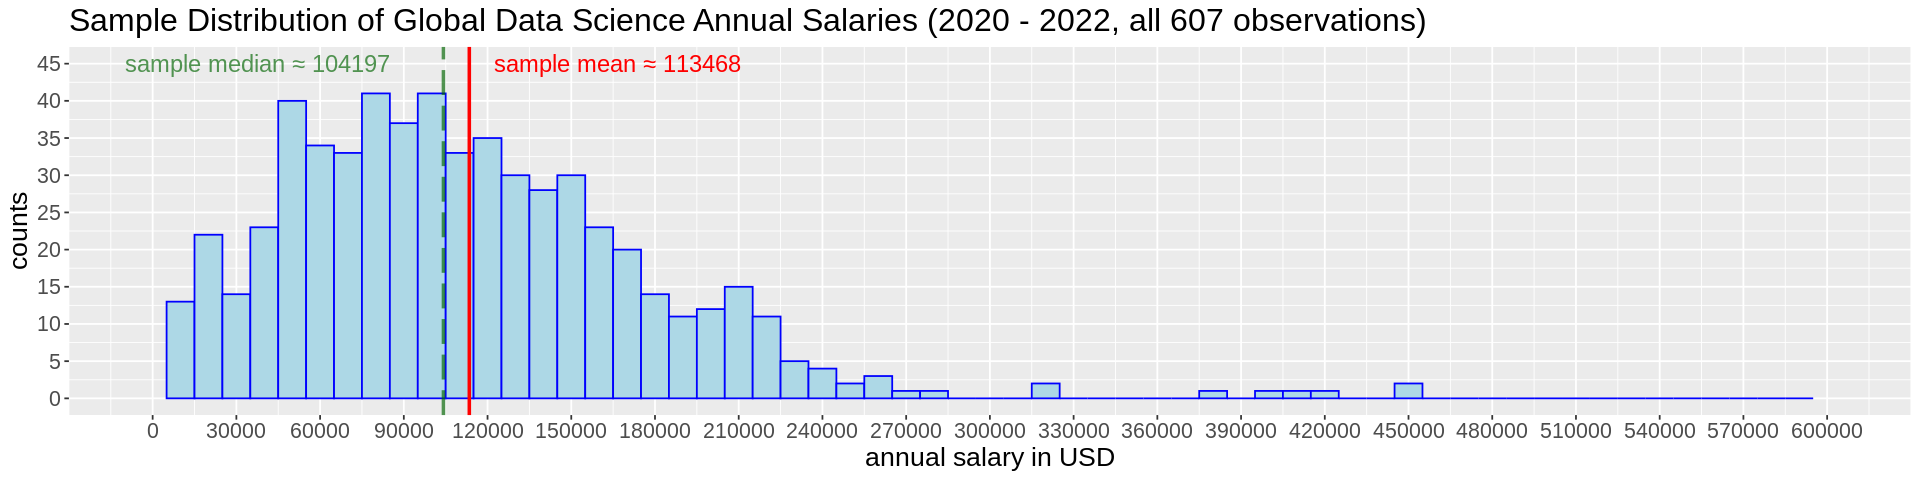

In [73]:
sample_stats <- df %>% 
    summarise(mean = mean(salary_in_usd),
             median = median (salary_in_usd))

mean_overall<- sample_stats[1] %>% pull()
median_overall <- sample_stats[2] %>% pull()

cat(" The over all sample mean is", mean_overall, "USD,","\n","and the over all sample median is", median_overall, "USD.")



options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)

all_salary_plot  <- df %>% 
    ggplot(aes(x = salary_in_usd)) + 
    geom_histogram(binwidth = 10000, colour = 'blue', fill = 'light blue') +
    labs(title = "Sample Distribution of Global Data Science Annual Salaries (2020 - 2022, all 607 observations)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +
    
    # add in sample mean and sample meadian as reference:
    geom_vline(xintercept = mean_overall, colour = 'red', size = 1, linetype = "solid") +
        annotate("text", x = mean_overall, y = 45,label = "sample mean ≈ 113468", color = "red", size=5, hjust = -0.1) +
    geom_vline(xintercept = median_overall, colour = 'dark green', alpha = 0.66, size = 1, linetype = "longdash") +
        annotate("text", x = median_overall, y = 45, label = "sample median ≈ 104197", color = "dark green", alpha = 0.66, size=5, hjust = 1.2)+ 

    # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 45), breaks = seq(0, 45, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 


all_salary_plot 

#### 2.3.2 Fully-remote v.s. Non-fully-remote 

Look into two groups for mean salary

 The sample mean of the fully-remote group is 122875 USD, 
 and the sample mean of the non-fully-remote group is 97502 USD.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


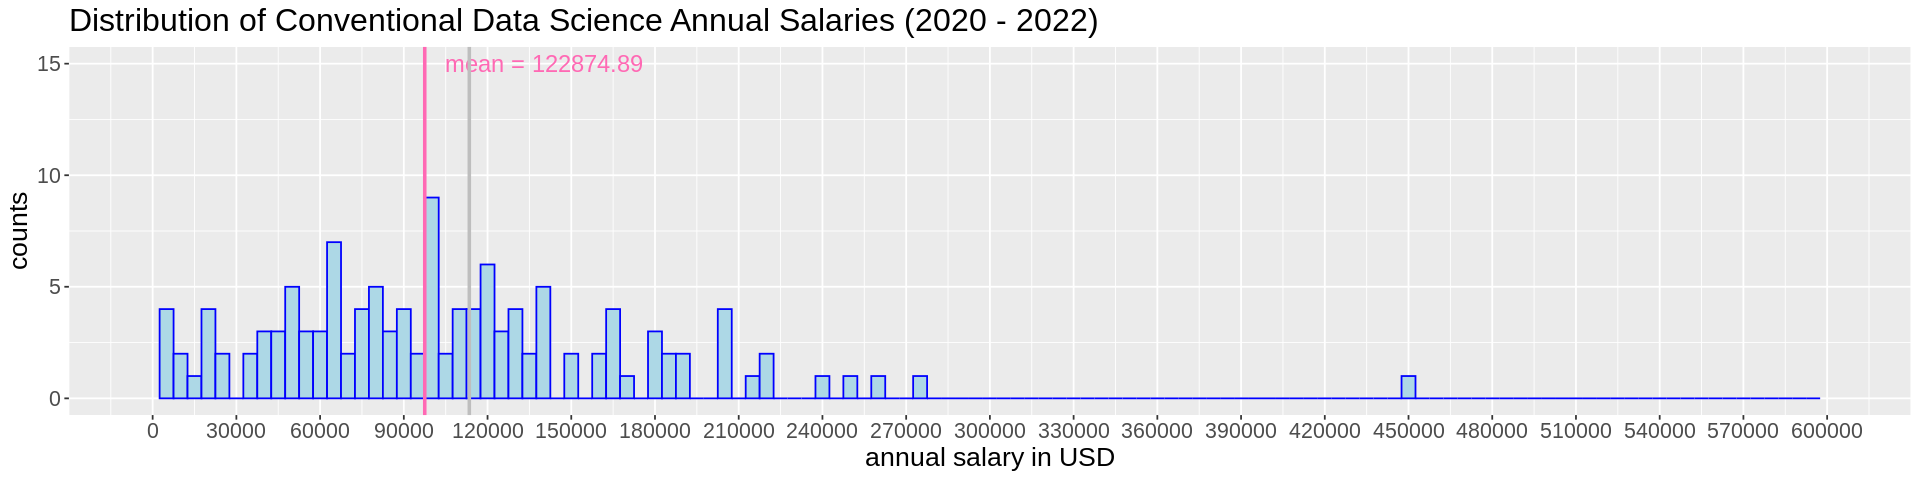

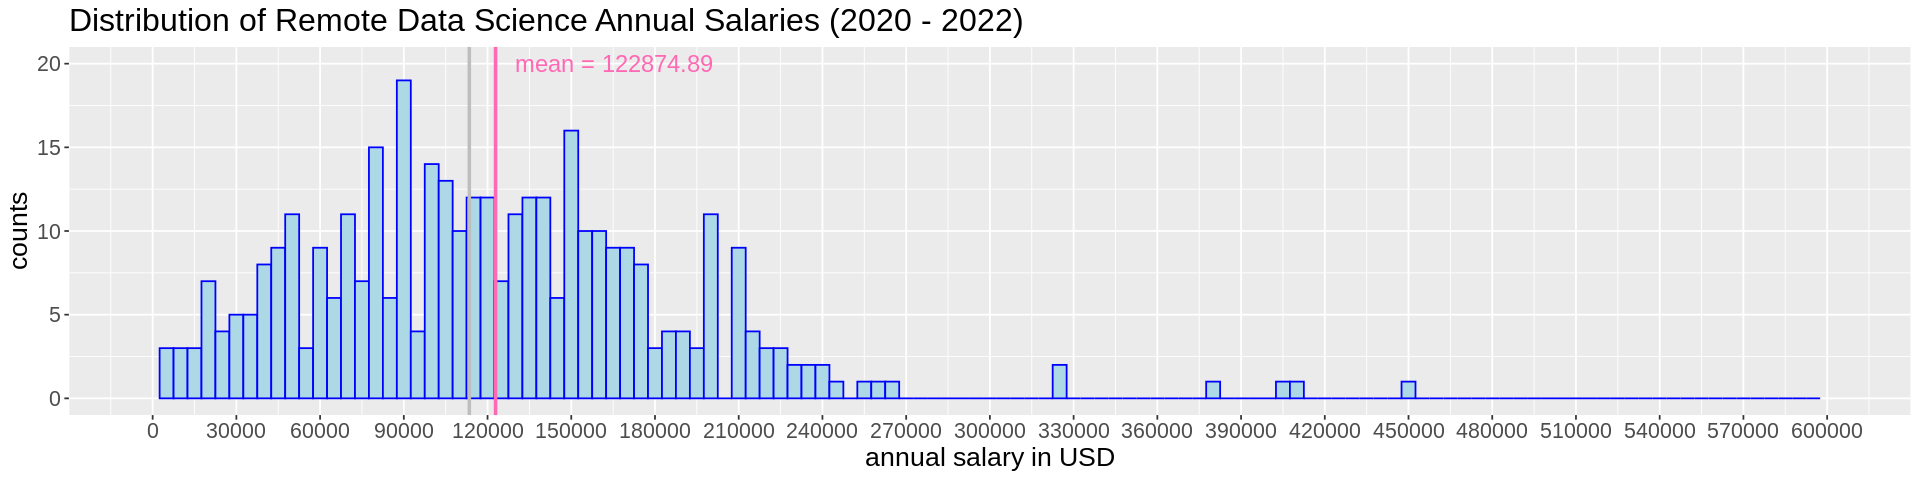

In [101]:
# 1. Fully_remote: 
fully_remote_mean <- fully_remote %>% 
    summarise(mean = mean(salary_in_usd)) %>% 
    pull()

# 2. Non_fully_remote:  
non_fully_remote_mean <- non_fully_remote %>% 
    summarise(mean = mean(salary_in_usd)) %>% 
    pull()

cat(" The sample mean of the fully-remote group is", fully_remote_mean, "USD,","\n","and the sample mean of the non-fully-remote group is", round(non_fully_remote_mean, 5), "USD.")


options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)

# non fully remote group:
conventional_plot <- df %>%
    filter(remote_ratio == 0 & 50) %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Conventional Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = 97502.38, colour = 'hot pink', size = 1, linetype = "solid") +
        annotate("text", x = 97502.38, y = 15, label = "mean = 122874.89", color = "hot pink", size = 5, hjust = -0.1) +
#     geom_vline(xintercept = 85000, colour = '#00827f', alpha = 0.36, size = 1, linetype = "longdash") +
#         annotate("text", x = 85000, y = 15, label = "median = 115717", color = '#00827f', alpha = 0.36, size=5, hjust = 1.1) +
    
    # add grey vertical lines for sample mean and sample meadian from sections above:
    geom_vline(xintercept = 113468, colour = 'grey', size = 1, linetype = "solid") +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 15), breaks = seq(0, 15, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

conventional_plot


# fully remote group:
remote_plot <- df %>%
    filter(remote_ratio == 100) %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Remote Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = 122874.89, colour = 'hot pink', size = 1, linetype = "solid") +
        annotate("text", x = 122874.89, y = 20, label = "mean = 122874.89", color = "hot pink", size = 5, hjust = -0.1) +
    # geom_vline(xintercept = 115717, colour = '#00827f', alpha = 0.36, size = 1, linetype = "longdash") +
    #     annotate("text", x = 115717, y = 20, label = "median = 115717", color = '#00827f', alpha = 0.36, size=5, hjust = 1.1) +

    # add grey vertical lines for sample mean and sample meadian from sections above:
    geom_vline(xintercept = 113468, colour = 'grey', size = 1, linetype = "solid") +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

remote_plot

-  for a better understanding of the uncertainty, we construct 95% confidence intervals for both group's sample means using percentile method with bootstraping

lower_ci,upper_ci
<dbl>,<dbl>
115910,130404


lower_ci,upper_ci
<dbl>,<dbl>
89522,105904


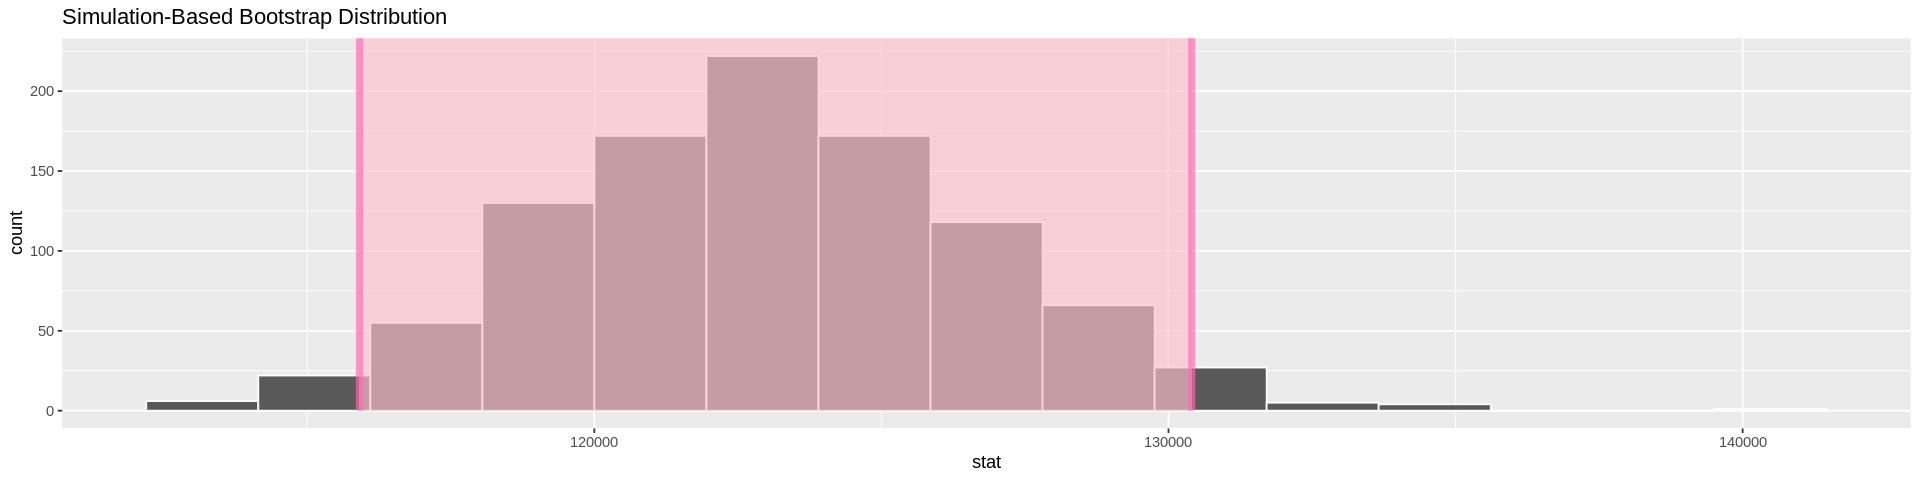

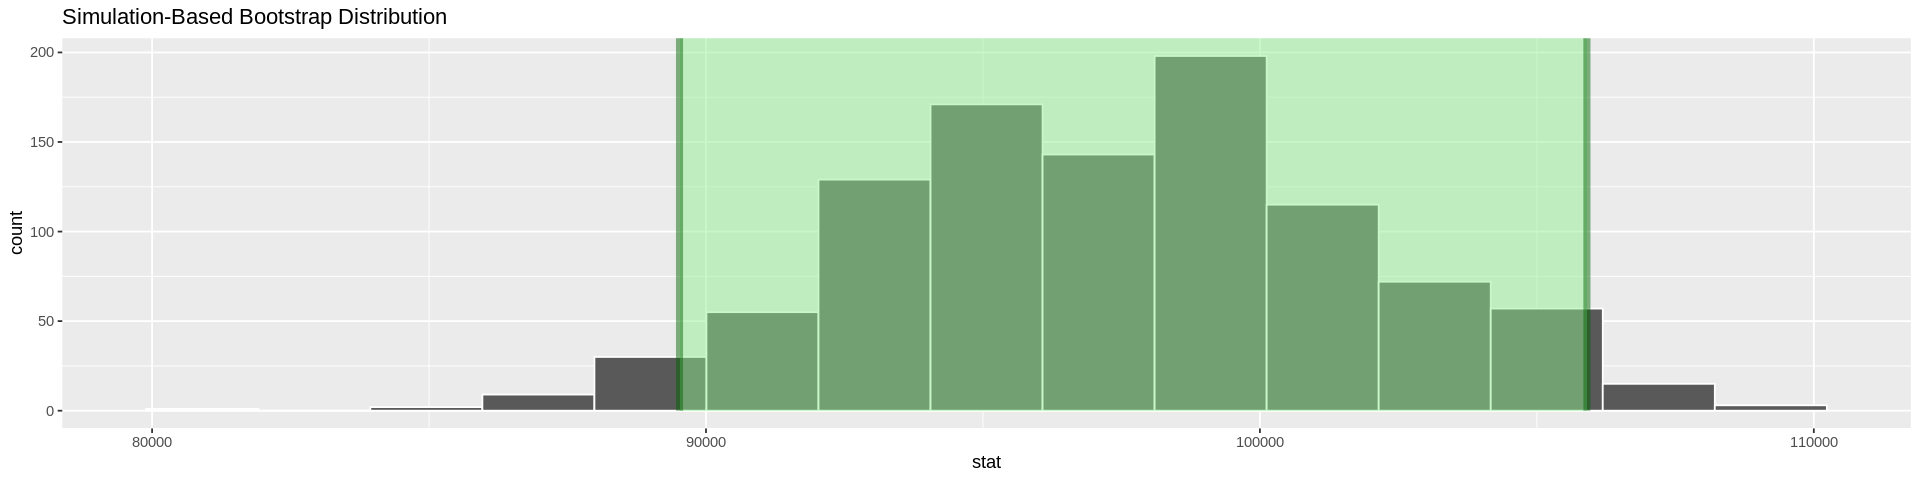

In [103]:
set.seed(6666)

# Fully-remote:

fully_remote_resample  <-  fully_remote %>%
    specify(response = salary_in_usd) %>%
    generate(reps = 1000, type = "bootstrap") %>%                        
    calculate(stat = "mean") 
# head(fully_remote_resample)

fully_remote_percentile_ci <- fully_remote_resample %>% 
  get_confidence_interval(level = 0.95, type = "percentile") 
fully_remote_percentile_ci

fully_remote_ci_plot <- 
    visualize(fully_remote_resample) + 
    shade_ci(endpoints = fully_remote_percentile_ci, color = "hotpink", fill = "pink", alpha = 0.66)
fully_remote_ci_plot


# Non-fully-remote:

non_fully_remote_resample  <- non_fully_remote %>%
    specify(response = salary_in_usd) %>%
    generate(reps = 1000, type = "bootstrap") %>%                        
    calculate(stat = "mean")    
# head(non_fully_remote_resample)

non_fully_remote_percentile_ci <- non_fully_remote_resample %>% 
  get_confidence_interval(level = 0.95, type = "percentile") 
non_fully_remote_percentile_ci

non_fully_remote_ci_plot <- 
    visualize(non_fully_remote_resample) + 
    shade_ci(endpoints = non_fully_remote_percentile_ci, color = "dark green", fill = "light green", alpha = 0.48)
non_fully_remote_ci_plot

To improve:
- covert to same scale with infer package
- title and labels with infer package



To write: 
- 95% confident that ...
- However, "Limitations of Confidence Interval:" see notes.

#### 2.2.x Boxplots

- to look at differences side by side 

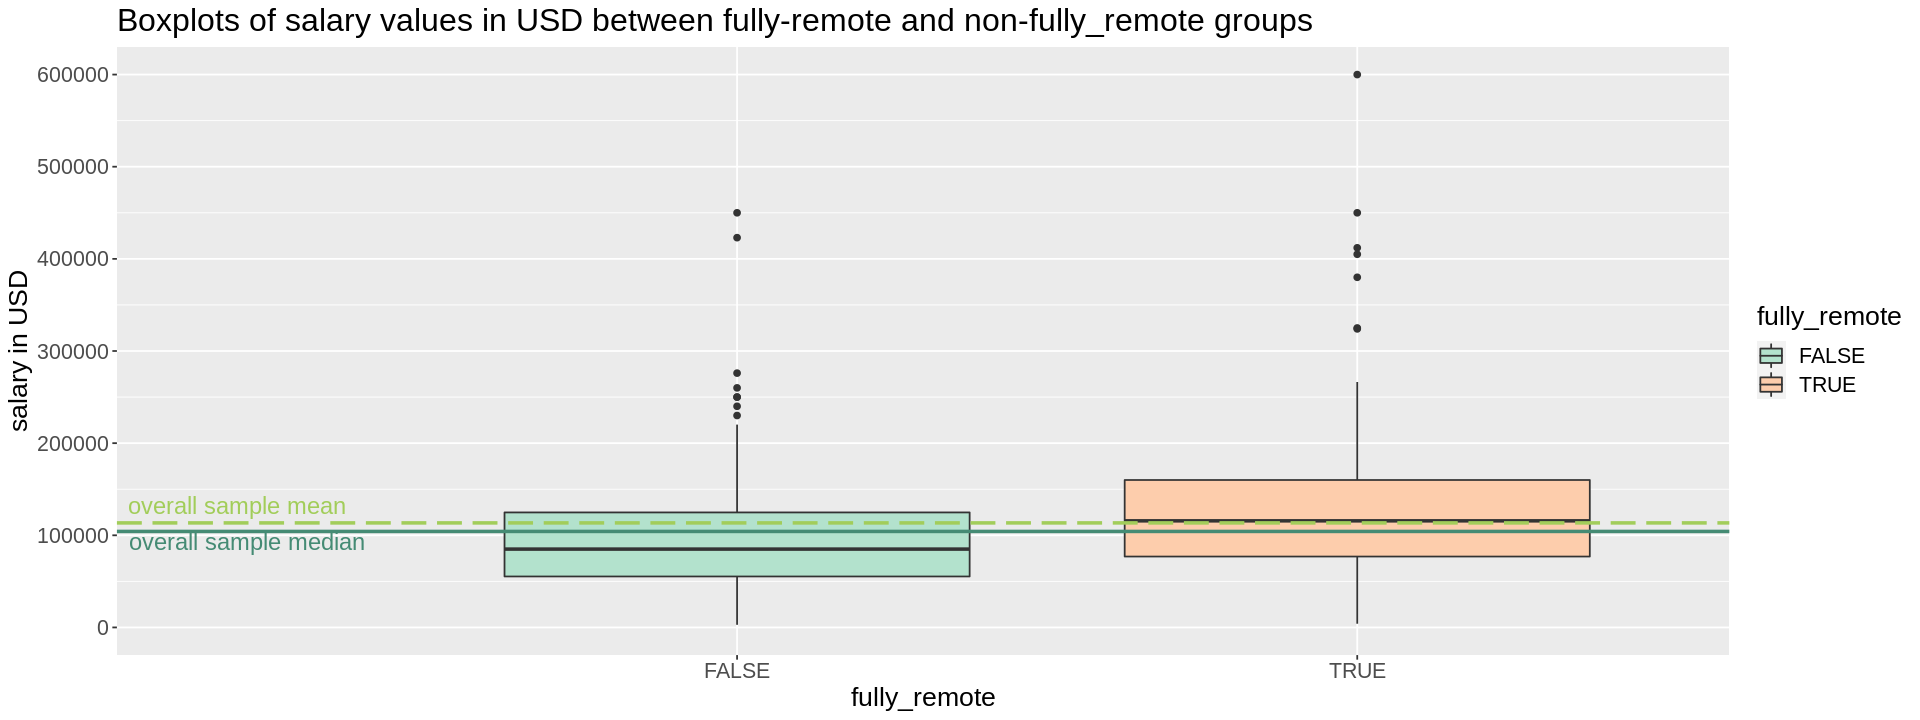

In [80]:
options(repr.plot.width = 16, repr.plot.height = 6)
options("scipen"=10, "digits"=4)

boxplots_all <- remote_binary %>%  
    ggplot(aes(x = fully_remote, y = salary_in_usd, fill = fully_remote)) + 
    scale_fill_brewer(palette = "Pastel2") +
    geom_boxplot() + 
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD between fully-remote and non-fully_remote groups") +
    theme(text = element_text(size=16)) +
    # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
    geom_hline(yintercept = mean_overall, color = "darkolivegreen3", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "darkolivegreen3", size=5, hjust = -0.05, vjust = -0.5) +
    geom_hline(yintercept = median_overall, color = "aquamarine4", size = 1, linetype = "solid") +
        annotate("text", x = 0, y = median_overall,label = "overall sample median", color = "aquamarine4", size=5, hjust = -0.05, vjust = 1.1)+

    # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 600000), breaks = seq(0, 600000, 100000)) 


boxplots_all

### 2.4 Data Exploratary Analysis


#### 2.4.1 Simulation-based Hypothesis Testing (Bootstrapping)

- look into the differences between the fully-remote and non-fully-remote group using hypothesis testing 

- based on boxplot, hypothesis as:
- H0:
- Ha: 

stat
<dbl>
25373


replicate,stat
<int>,<dbl>
1,-672.4
2,-3585.2
3,366.9
4,-9779.0
5,-717.3
6,10111.2


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


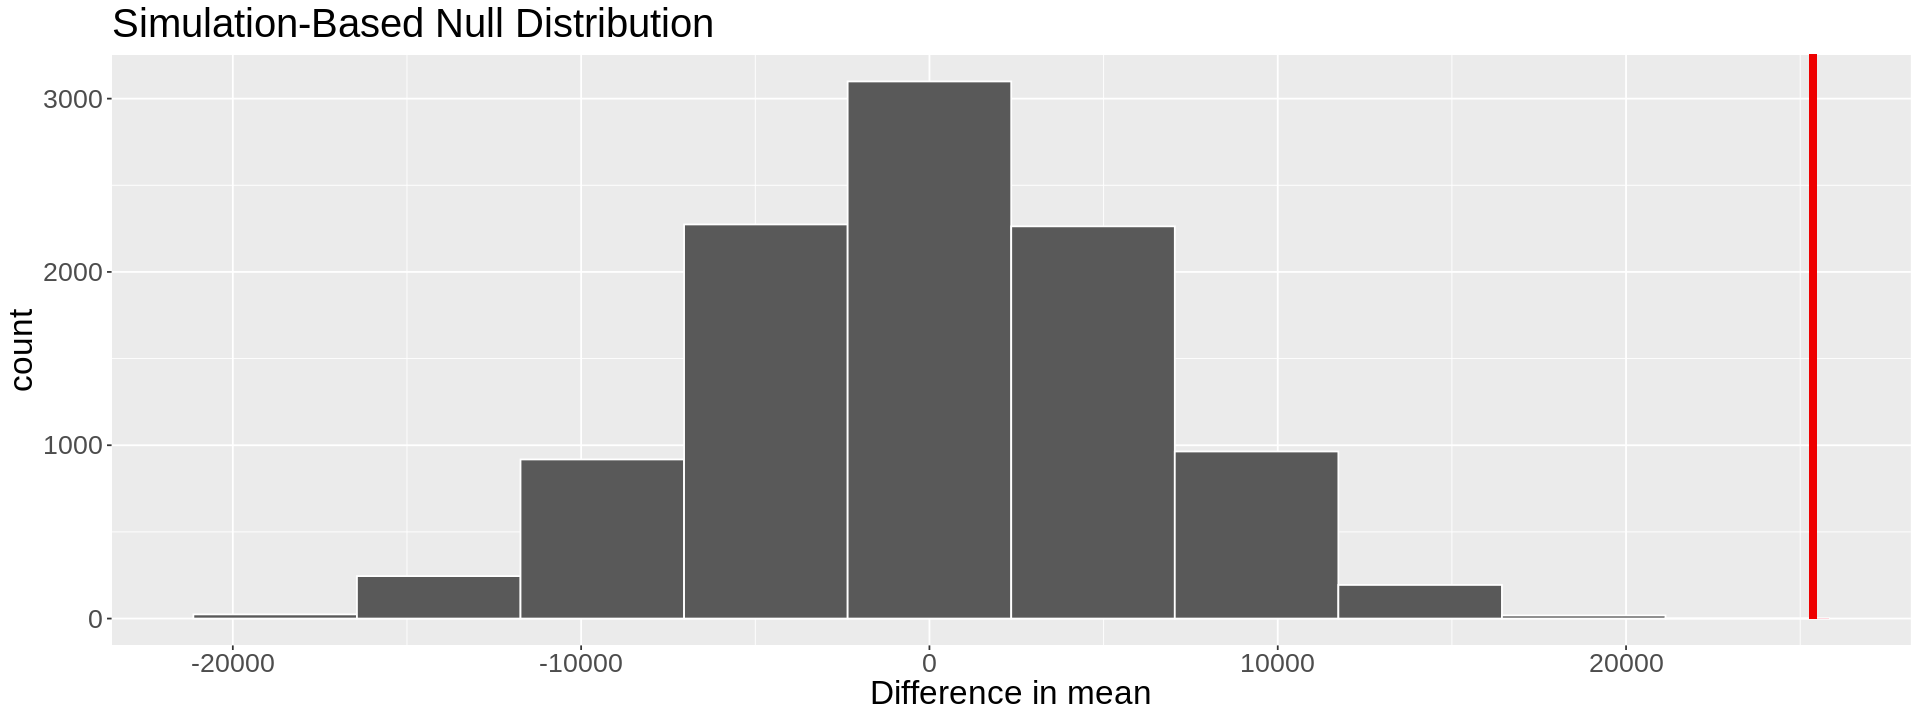

In [105]:
#calculate observed test statistic 
obs_diff_in_means <- 
    remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
obs_diff_in_means

# build the null distribution
null_dist <-remote_binary  %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
head(null_dist)

# visualization 
options(repr.plot.width = 16, repr.plot.height = 6)
options("scipen"=10, "digits"=4)

diff_in_medians_plot <-
    visualize(null_dist, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
    xlab("Difference in mean") +
    theme(text = element_text(size = 20))
diff_in_medians_plot

# get p value
p_value <- null_dist %>% 
    get_p_value(obs_stat = obs_diff_in_means, direction = "right")
p_value


#### 2.4.2 Theory-based Hypothesis Testing (Asymptotics)

In [89]:
t_test_results <- tidy(t.test(x = remote_binary %>% filter(fully_remote == "TRUE") %>% pull(salary_in_usd), 
                              y = remote_binary %>% filter(fully_remote == "FALSE") %>% pull(salary_in_usd),
                              alternative = "greater"))

t_test_results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
25373,122875,97502,4.452,0.000005279,490.7,15980,Inf,Welch Two Sample t-test,greater


- very small p-value, reject H0
- result in favour of hypothesis of difference


- consider there are many factors, need to know the variation; given skewness and observed outliers in boxplot, scale parameter, use IQR.

- but how big and where is the difference? 
- Using IQR to look closely into the differences


~notice a big outlier?~
    ~may affect results?~
~executive position are not representative of population, would therefore remove?~

25% 
76944

75% 
160000

[1] 115717

25% 
55314

75% 
124833

[1] 85000

25% 
76944

75% 
160000

[1] 115717

25% 
55314

75% 
124833

[1] 85000

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


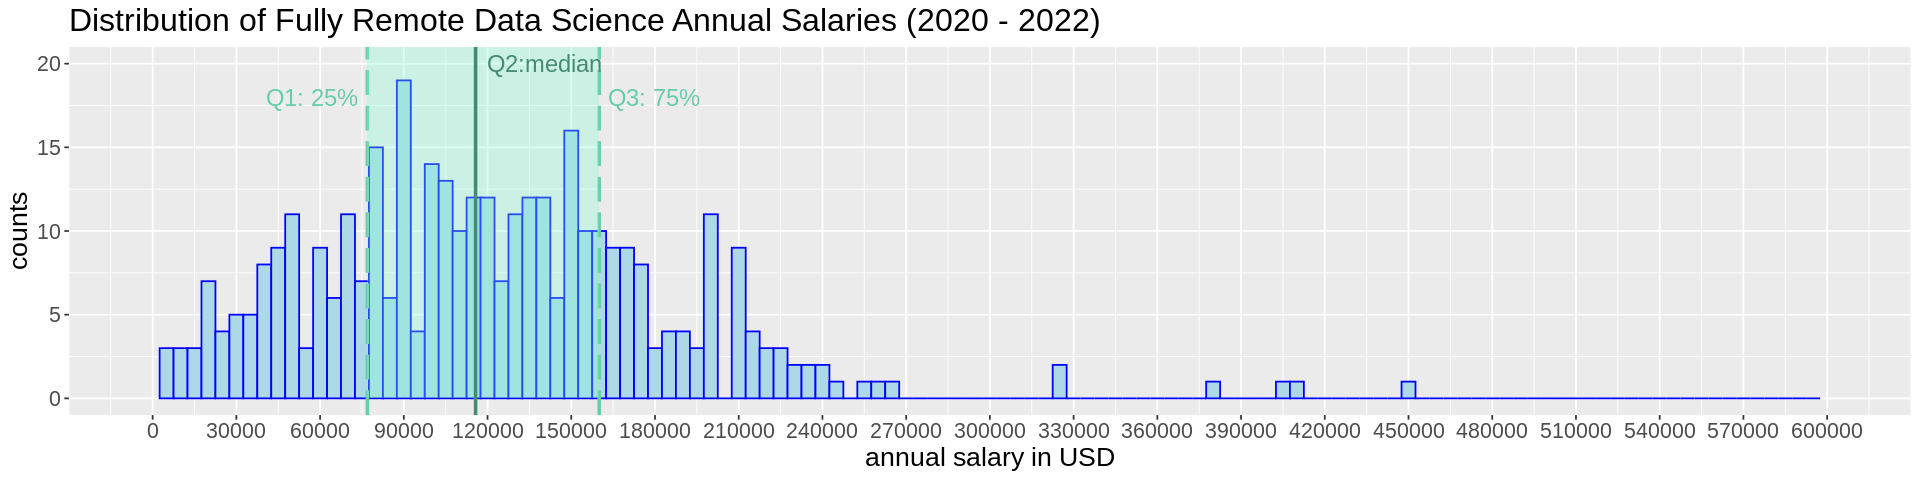

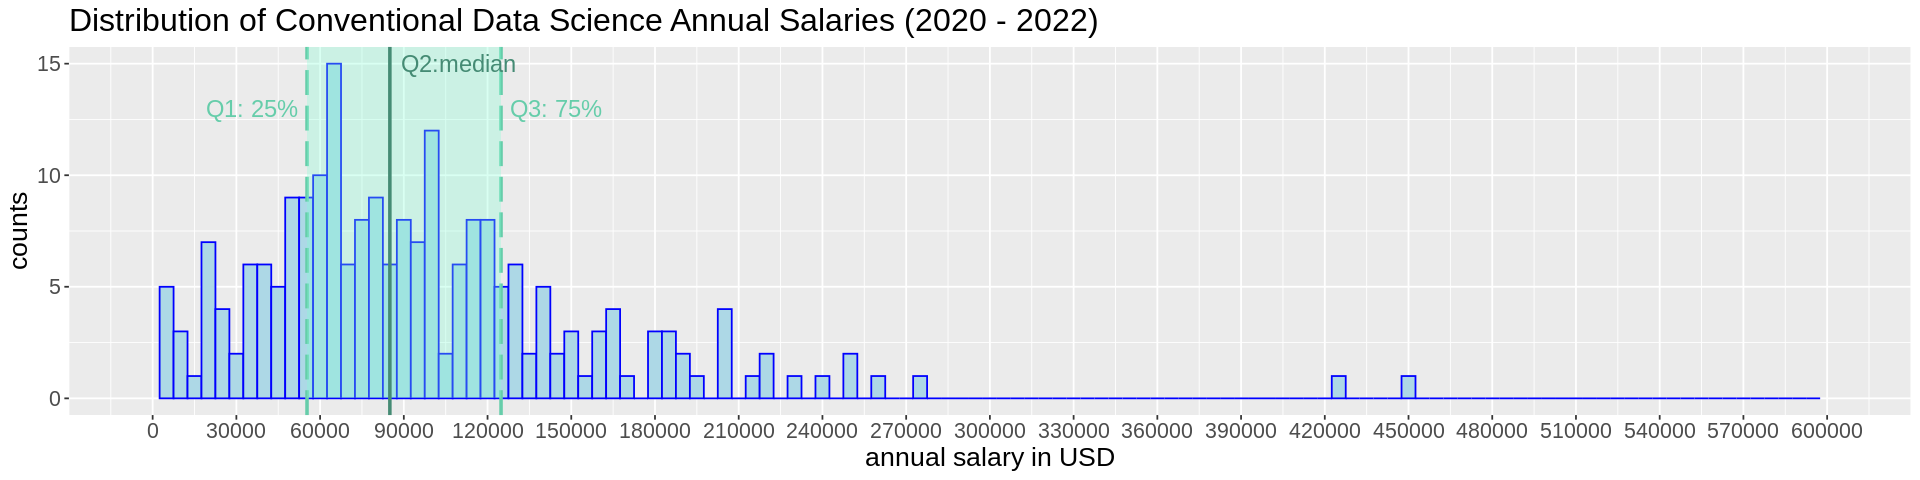

In [107]:
options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)


## Inter-quartile range:

# fully remote group:
lower_quantile_fully_remote <- 
    fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.25)
lower_quantile_fully_remote

upper_quantile_fully_remote <- 
    fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.75)
upper_quantile_fully_remote

median_fully_remote <- fully_remote %>% 
    summarise(median = median(salary_in_usd)) %>% 
    pull()
median_fully_remote


# non fully remote group:
lower_quantile_non_fully_remote <- 
    non_fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.25)
lower_quantile_non_fully_remote

upper_quantile_non_fully_remote <- 
    non_fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.75)
upper_quantile_non_fully_remote

median_non_fully_remote <- non_fully_remote %>% 
    summarise(median = median(salary_in_usd)) %>% 
    pull()
median_non_fully_remote


# fully remote group:
remote_plot <- fully_remote %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Fully Remote Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +


    geom_vline(xintercept = lower_quantile_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = lower_quantile_fully_remote, y = 18, label = "Q1: 25%", color = 'aquamarine3', size = 5, hjust = 1.1) +
    geom_vline(xintercept = upper_quantile_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = upper_quantile_fully_remote, y = 18, label = "Q3: 75%", color = 'aquamarine3', size = 5, hjust = -0.1) +
    annotate("rect", xmin = lower_quantile_fully_remote, xmax = upper_quantile_fully_remote, ymin = 0, ymax = Inf,
             fill = "aquamarine",
             alpha = 0.3) +
    geom_vline(xintercept = median_fully_remote, colour = 'aquamarine4', size = 1, linetype = "solid") +
        annotate("text", x = median_fully_remote, y = 20, label = "Q2:median", color = 'aquamarine4', size=5, hjust = -0.1) +
    


    # # add in coloured vertical lines with labels for group mean and group meadian as reference:
    # geom_vline(xintercept = 122874.89, colour = 'hot pink', size = 1, linetype = "solid") +
    #     annotate("text", x = 122874.89, y = 20, label = "mean = 122874.89", color = "hot pink", size = 5, hjust = 2.5) +
    # geom_vline(xintercept = 115717, colour = '#00827f', alpha = 0.36, size = 1, linetype = "longdash") +
    #     annotate("text", x = 115717, y = 20, label = "median = 115717", color = '#00827f', alpha = 0.36, size=5, hjust = 3) +

    # # add grey vertical lines for sample mean and sample meadian from sections above:
    # geom_vline(xintercept = 113468, colour = 'grey', size = 1, linetype = "solid") +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

remote_plot



# non fully remote group:
plot_IQR_non_fully_remote <- non_fully_remote %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Conventional Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = lower_quantile_non_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = lower_quantile_non_fully_remote, y = 13, label = "Q1: 25%", color = 'aquamarine3', size = 5, hjust = 1.1) +
    geom_vline(xintercept = upper_quantile_non_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = upper_quantile_non_fully_remote, y = 13, label = "Q3: 75%", color = 'aquamarine3', size = 5, hjust = -0.1) +
    annotate("rect", xmin = lower_quantile_non_fully_remote, xmax = upper_quantile_non_fully_remote, ymin = 0, ymax = Inf,
             fill = "aquamarine",
             alpha = 0.3) +
    geom_vline(xintercept = median_non_fully_remote, colour = 'aquamarine4', size = 1, linetype = "solid") +
        annotate("text", x = median_non_fully_remote, y = 15, label = "Q2:median", color = 'aquamarine4', size=5, hjust = -0.1) +
    
    # # add grey vertical lines for sample mean and sample meadian from sections above:
    # geom_vline(xintercept = 113468, colour = 'grey', size = 1, linetype = "solid") +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 15), breaks = seq(0, 15, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

plot_IQR_non_fully_remote




# The warning message is only caused by adjusting the y-axis breaks and limits, which does not affect calculation for analysis.
# We double-checked the raw data, and there is no "missing values" for the two removed rows in the dataset itself.
# This specific data visualization warning message will be dealt with within the report.


- conduct CI for IQR using bootstrapping

In [86]:
iqr_fully_remote  <-  fully_remote %>%
    select(salary_in_usd) %>%
    rep_sample_n(size = nrow(fully_remote), reps = 10000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarize(IQR = quantile(x = salary_in_usd,0.75) - quantile(x = salary_in_usd,0.25)) %>%
    ungroup() %>%
    summarize(upper = quantile(x = IQR, 0.975), lower = quantile(x = IQR, 0.025))

iqr_non_fully_remote  <-  non_fully_remote %>%
    select(salary_in_usd) %>%
    rep_sample_n(size = nrow(non_fully_remote), reps = 10000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarize(IQR = quantile(x = salary_in_usd,0.75) - quantile(x = salary_in_usd,0.25)) %>%
    ungroup() %>%
    summarize(upper = quantile(x = IQR, 0.975), lower = quantile(x = IQR, 0.025))
 
 
iqr_fully_remote
iqr_non_fully_remote


upper,lower
<dbl>,<dbl>
93175,74408


upper,lower
<dbl>,<dbl>
80762,58690


- hypothesis test suggest big difference, can't really tell from IQR.

- Just knowing it's different/bigger is not quite informative for our interests.

- does that difference differ in regions? what about gaps between payscales in different countries?

In [108]:
## country means across population 

# within country cross remote
us_remote_binary <- remote_binary %>% 
    filter(company_location == "US")
# head(us_remote_binary)

others_remote_binary <- remote_binary %>% 
    filter(company_location != "US")
# head(others_remote_binary)


# calculate observed test statistic 
us_obs_diff_in_means <- 
    us_remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# us_obs_diff_in_means

# build the null distribution
us_null_dist <- us_remote_binary %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
# head(us_null_dist)

# # visualization 
# diff_in_medians_plot <-
#     visualize(null_dist, bins = 10) + 
#     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
#     xlab("Difference in mean") +
#     theme(text = element_text(size = 20))
# diff_in_medians_plot

# get p value
us_p_value <- us_null_dist %>% 
    get_p_value(obs_stat = us_obs_diff_in_means, direction = "right") %>%
    pull()
# us_p_value


#calculate observed test statistic 
others_obs_diff_in_means <- 
    others_remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# obs_diff_in_means

# build the null distribution
others_null_dist <- others_remote_binary %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
# head(others_null_dist)

# # visualization 
# diff_in_medians_plot <-
#     visualize(null_dist, bins = 10) + 
#     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
#     xlab("Difference in mean") +
#     theme(text = element_text(size = 20))
# diff_in_medians_plot

# get p value
others_p_value <- others_null_dist %>% 
    get_p_value(obs_stat = others_obs_diff_in_means, direction = "right") %>%
    pull()
# others_p_value


cat("p-value for US region:", us_p_value,  "\n", "p-value for other countires:", others_p_value)


 p-value for US region: 0.1319 
 p-value for other countires: 0.7065


- given obvious differences among different regions and clear outliers in each group, choose to use IQR instead of repeated hypothesis testing to conduct more in-depth investigations about how salaries differ between fully-remote and conventional groups among different regions

- look into countries to check potential regional payscale differences
- US, majority of data, advanced in data science, so need to check as a single group
- Canada is most relevant to both authors and readers, so will also investigate as a single group
- re-group the rest of the countires for comparison. 

In [111]:
# tally_remote_binary <- remote_binary %>%
#     group_by(company_location) %>%
#     summarise(total = length(company_location))
# tally_remote_binary
    

# Duplicate original cleaned dataframe to re-assigned region groups
remote_binary_region_groups <- remote_binary

# Re-categorize countries into US, Canada, and Others
remote_binary_region_groups["company_location"][remote_binary_region_groups["company_location"] != "US"] <- "Others"
# glimpse(remote_binary_region_groups)
# head(remote_binary_region_groups)
# remote_binary_region_groups

tally_remote_binary_region_groups <- remote_binary_region_groups %>%
    group_by(company_location) %>%
    summarise(total = length(company_location))
tally_remote_binary_region_groups

# remote_binary_region_groups %>%
#     filter(company_location != "US") %>%
#     filter(company_location != "Others") 
# remote_binary_region_groups


company_location,total
<chr>,<int>
Others,242
US,346


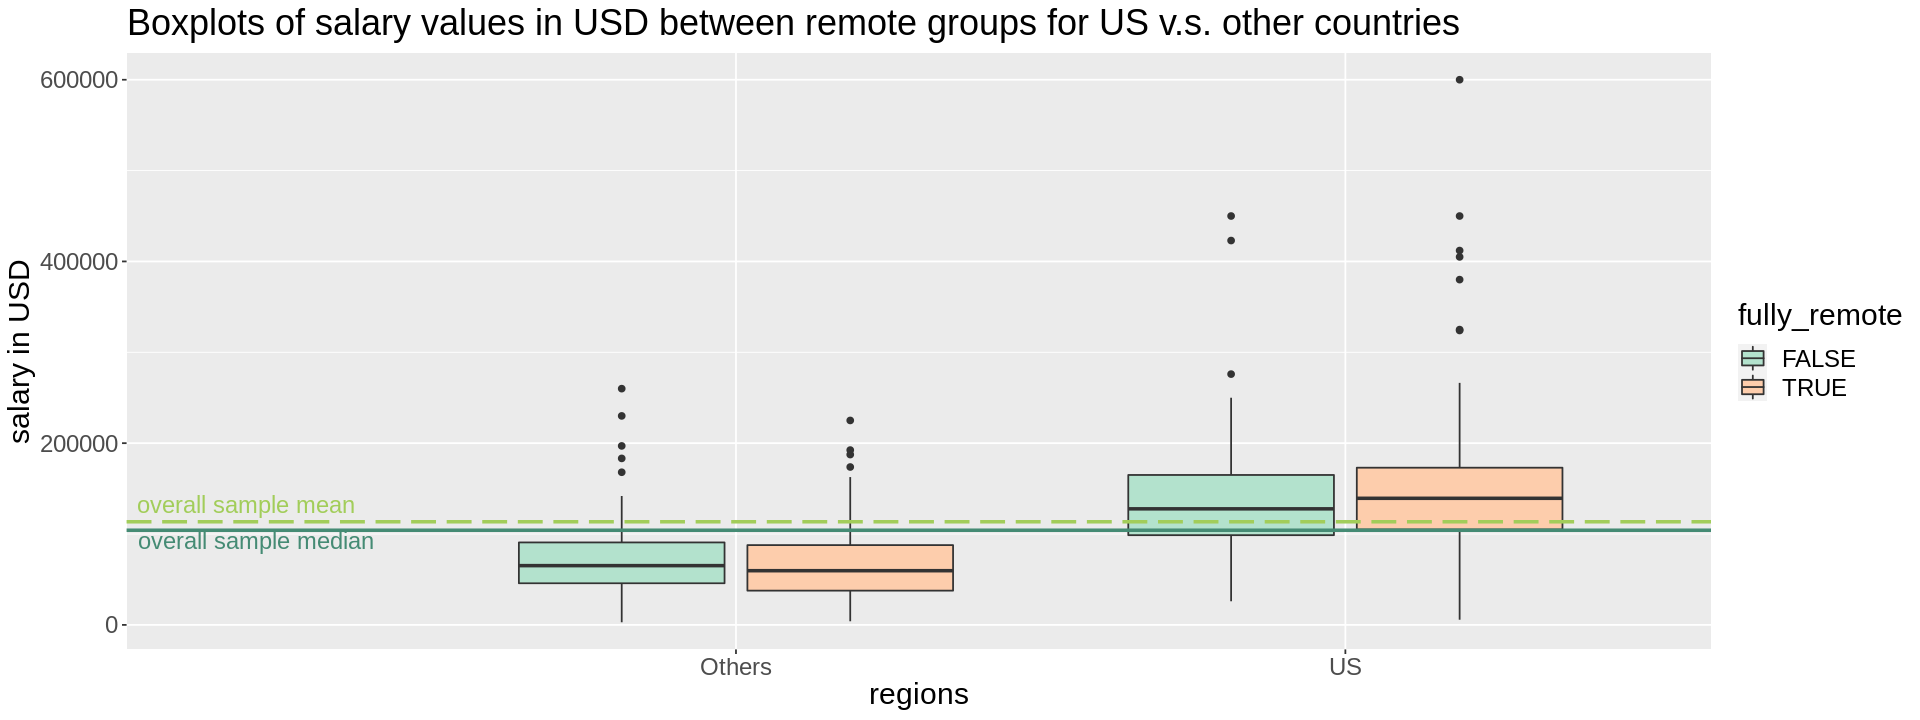

In [117]:
options(repr.plot.width = 16, repr.plot.height = 6)
options("scipen"=10, "digits"=4)

boxplots_regions_remote <- remote_binary_region_groups %>%  
    ggplot(aes(x = company_location, y = salary_in_usd, fill = fully_remote)) + 
    scale_fill_brewer(palette = "Pastel2") +
    geom_boxplot() + 
    xlab("regions") +
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD between remote groups for US v.s. other countries") +
    theme(text = element_text(size=18)) +
    # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
    geom_hline(yintercept = mean_overall, color = "darkolivegreen3", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "darkolivegreen3", size=5, hjust = -0.05, vjust = -0.5) +
    geom_hline(yintercept = median_overall, color = "aquamarine4", size = 1, linetype = "solid") +
        annotate("text", x = 0, y = median_overall,label = "overall sample median", color = "aquamarine4", size=5, hjust = -0.05, vjust = 1.1)

boxplots_regions_remote

In [62]:
# ## change mean to median 

# # hypothesis test (two group)
# # make the remote_ratio column two categories, so that it is easier to work with
# # remote_binary <- df %>% 
# #     mutate(full_remote = (remote_ratio == 100)) %>% 
# #     select(-remote_ratio)
# # head(remote_binary)

# #calculate observed test statistic 
# obs_diff_in_meds <- remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# obs_diff_in_meds

# # build the null distribution
# null_dist_meds <- remote_binary  %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# head(null_dist_meds)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# p_value_meds <- null_dist_meds %>% 
#     get_p_value(obs_stat = obs_diff_in_meds, direction = "right")
# p_value_meds


*Make sure to **interpret the results you obtain**. It’s not enough to just state what a 90% confidence interval is, for example.*

*Ensure your tables and/or figures are labeled with a figure/table number.
**Do you think one of bootstrapping or asymptotics is more appropriate than the other? Why or why not?** Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.*

### 2.4 Results and interpretations

# 3. Discussion
*In this section, you’ll **interpret the results** you obtained in the previous section*
***with respect to the main question/goal of your project.***
- *Summarize what you found, and the implications/impact of your findings.*
- *If relevant, discuss whether your results were what you expected to find.*
- *Discuss future questions/research this study could lead to.*

### 3.1 Findings and implications

### 3.2 Expectations 

### 3.3 Future questions and research

# 4. References
*The same instructions for your proposal also applies here. You only need to **make changes if necessary (e.g., if feedback indicates so).***

“Ai-Jobs.net Salaries.” Salaries.ai, https://salaries.ai-jobs.net/. 

Bhatia, Ruchi. “Data Science Job Salaries.” Kaggle, 15 June 2022, https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries. 

Brynjolfsson, Erik, et al. “Covid-19 and Remote Work: An Early Look at US Data.” 2020, https://doi.org/10.3386/w27344.

Galanti, Teresa et al. “Work From Home During the COVID-19 Outbreak: The Impact on Employees' Remote Work Productivity, Engagement, and Stress.” Journal of occupational and environmental medicine vol. 63,7 (2021): e426-e432. doi:10.1097/JOM.0000000000002236